In [225]:
import requests
!pip install pandas numpy sklearn xgboost seaborn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



import seaborn as sns
import xgboost as xgb

In [216]:
response = requests.get('https://gist.githubusercontent.com/yppmark/d907dc265a84cac76ba7/raw/5b8a1c8df62cde2ba2b599cfa6404c6fd165ca02/SleepInMammals.csv', allow_redirects=True)
open('mammal.csv', 'wb').write(response.content)
response = requests.get('https://esapubs.org/archive/ecol/E090/184/PanTHERIA_1-0_WR93_Aug2008.txt', allow_redirects=True)
open('pantheria.tsv', 'wb').write(response.content)

1549575

In [217]:
# may have some inaccuracies
species_dict = {
    "african giant pouched rat": "cricetomys gambianus",
    "asian elephant": "elephas maximus",
    "baboon": "papio hamadryas",
    "big brown bat": "eptesicus fuscus",
    "brazilian tapir": "tapirus terrestris",
    "cat": "felis catus",
    "chimpanzee": "pan troglodytes",
    "chinchilla": "chinchilla lanigera",
    "cow": "bos taurus",
    "eastern american mole": "scalopus aquaticus",
    "echidna": "tachyglossus aculeatus",
    "european hedgehog": "erinaceus europaeus",
    "galago": "galago spp.",
    "goat": "capra hircus",
    "golden hamster": "mesocricetus auratus",
    "gray seal": "halichoerus grypus",
    "ground squirrel": "spermophilus spp.",
    "guinea pig": "cavia porcellus",
    "horse": "equus ferus caballus",
    "lesser short-tailed shrew": "blarina brevicauda",
    "little brown bat": "myotis lucifugus",
    "human": "homo sapiens",
    "mouse": "mus musculus",
    "musk shrew": "suncus murinus",
    "n. american opossum": "didelphis virginiana",
    "nine-banded armadillo": "dasypus novemcinctus",
    "owl monkey": "aotus spp.",
    "patas monkey": "erythrocebus patas",
    "phanlanger": "phalanger spp.",
    "pig": "sus domesticus",
    "rabbit": "oryctolagus cuniculus",
    "rat": "rattus norvegicus",
    "red fox": "vulpes vulpes",
    "rhesus monkey": "macaca mulatta",
    "sheep": "ovis aries",
    "tenrec": "tenrec ecaudatus",
    "tree hyrax": "dendrohyrax arboreus",
    "tree shrew": "tupaia spp.",
    "vervet": "chlorocebus pygerythrus",
    "water opossum": "chironectes minimus"
}


In [218]:
# combine datasets
mammal = pd.read_csv('mammal.csv')
pantheria = pd.read_csv('pantheria.tsv', sep='\t')
# lots of output
print(mammal.head())
print(pantheria.head())
mammal['Species of animal'] = mammal['Species of animal'].str.lower()
mammal['Species of animal'] = mammal['Species of animal'].str.strip()
pantheria['MSW93_Binomial'] = pantheria['MSW93_Binomial'].str.lower()
pantheria['MSW93_Binomial'] = pantheria['MSW93_Binomial'].str.strip()

mammal['MSW93_Binomial'] = mammal['Species of animal'].map(species_dict)

mammal = mammal.merge(pantheria, on='MSW93_Binomial', how='left')
# print(mammal.head())
# some animals are not in the other dataset, noticing many are domesticated
print(mammal[mammal['26-6_GR_MinLong_dd'].isnull()][['MSW93_Binomial', 'Species of animal']])

           Species of animal  Body Weight (kg)  Brain Weight (g)  \
0  African giant pouched rat             1.000               6.6   
1             Asian elephant          2547.000            4603.0   
2                     Baboon            10.550             179.5   
3              Big brown bat             0.023               0.3   
4            Brazilian tapir           160.000             169.0   

   Slow wave sleep (hrs/day)  Paradoxical sleep (hrs/day)  \
0                        6.3                          2.0   
1                        2.1                          1.8   
2                        9.1                          0.7   
3                       15.8                          3.9   
4                        5.2                          1.0   

   Total sleep (hrs/day)  Maximum life span (years)  Gestation time (days)  \
0                    8.3                        4.5                   42.0   
1                    3.9                       69.0                 

In [219]:
# preprocess
# some attributes may be -999, hoping that regression can learn around this. cannot remove/impute data. too small and very
mammal.replace(-999, np.nan, inplace=True)

pd.set_option('display.max_rows', None)
print(mammal.dtypes)
print(mammal.columns)
# metabolic/environment/physical characteristics are important, so I will keep those
# I'll cut all object columns but species

mammal = mammal.select_dtypes(exclude='object').join(mammal['Species of animal'])
# print(mammal.head())
# the indices have a meaningful ordering, so I will not one-hot encode them
# total = nrem + rem, so I could just regress nrem, rem
y = mammal[['Slow wave sleep (hrs/day)', 'Paradoxical sleep (hrs/day)', 'Total sleep (hrs/day)', 'Species of animal']]
# let's capture variables related to mass, brain weight, life span, environmental risk, metabolism/diet and population dynamics
X = mammal.drop(y.columns, axis=1)[['Body Weight (kg)', 'Brain Weight (g)', 'Maximum life span (years)', 'Gestation time (days)', 'Predation index', 'Sleep exposure index', 'Overall danger index', '18-1_BasalMetRate_mLO2hr', '22-1_HomeRange_km2', '6-1_DietBreadth', '21-1_PopulationDensity_n/km2', '10-1_PopulationGrpSize']]
print(y.head())
# print(X.head())
print(y.describe())
print(X.describe())

Species of animal                object
Body Weight (kg)                float64
Brain Weight (g)                float64
Slow wave sleep (hrs/day)       float64
Paradoxical sleep (hrs/day)     float64
Total sleep (hrs/day)           float64
Maximum life span (years)       float64
Gestation time (days)           float64
Predation index                   int64
Sleep exposure index              int64
Overall danger index              int64
MSW93_Binomial                   object
MSW93_Order                      object
MSW93_Family                     object
MSW93_Genus                      object
MSW93_Species                    object
1-1_ActivityCycle               float64
5-1_AdultBodyMass_g             float64
8-1_AdultForearmLen_mm          float64
13-1_AdultHeadBodyLen_mm        float64
2-1_AgeatEyeOpening_d           float64
3-1_AgeatFirstBirth_d           float64
18-1_BasalMetRate_mLO2hr        float64
5-2_BasalMetRateMass_g          float64
6-1_DietBreadth                 float64


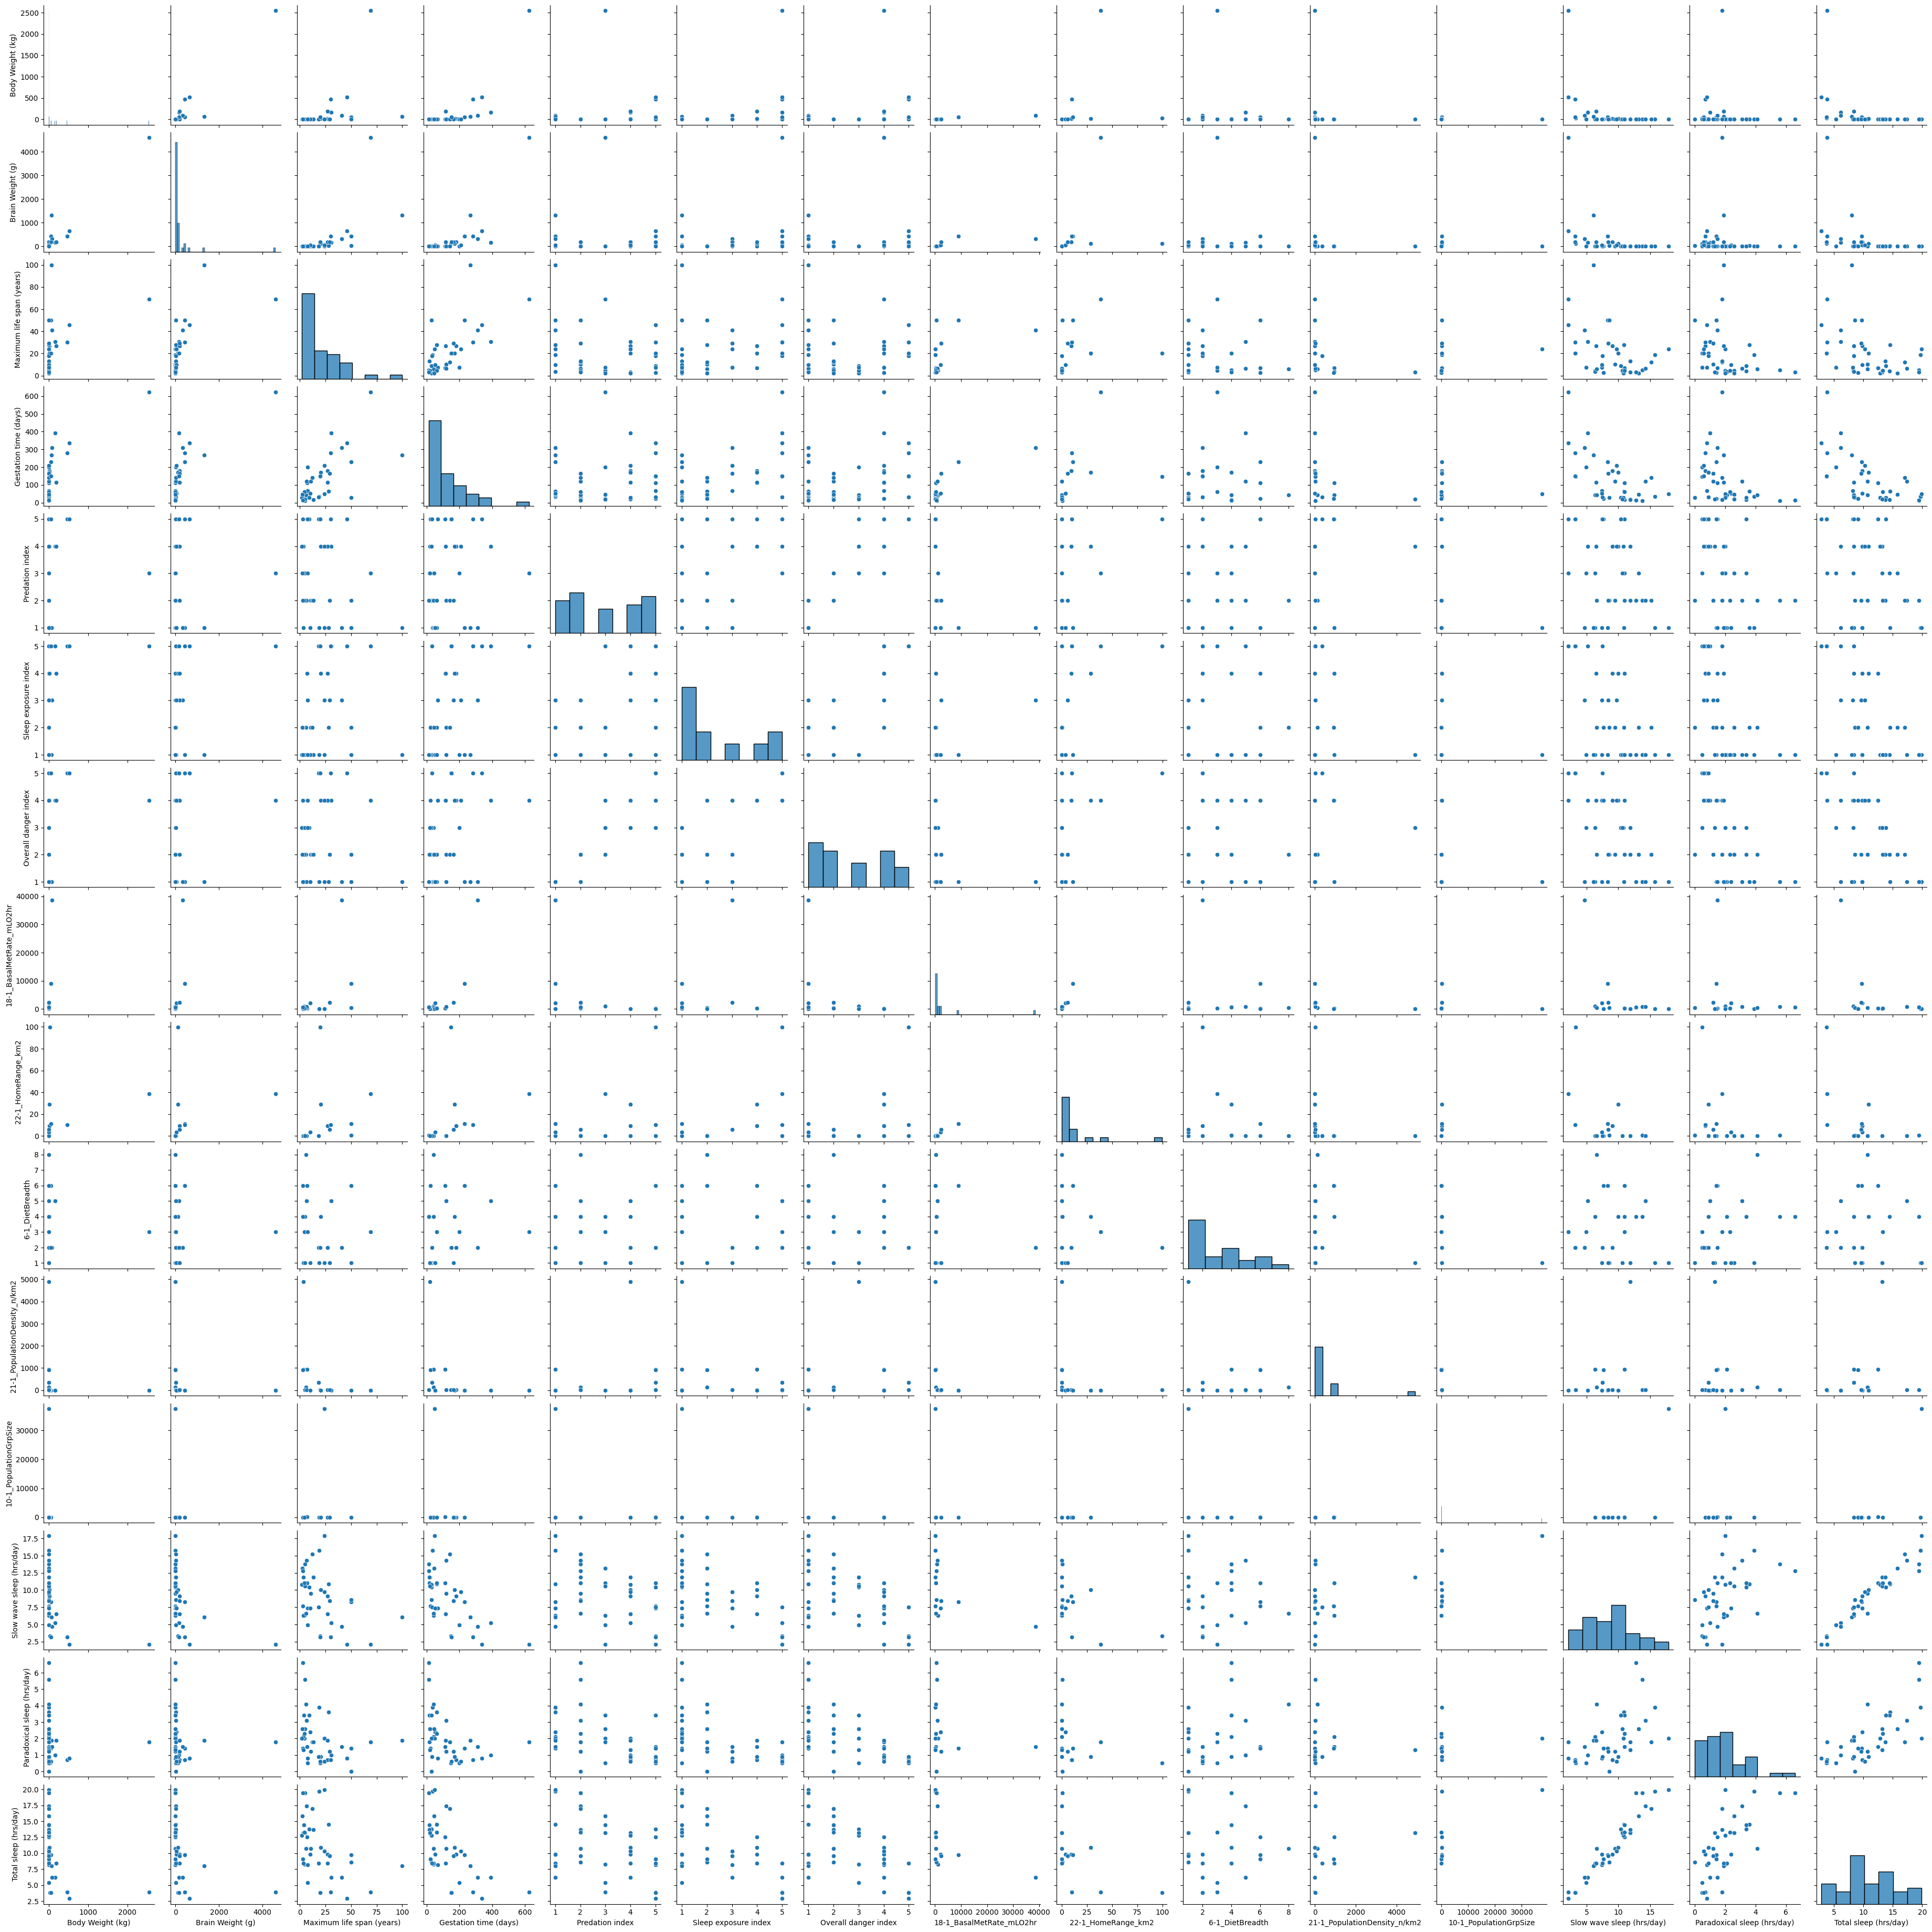

In [220]:
# visualize (pairplots)
sns.pairplot(X.join(y))
# a bit to parse through- I get it. could go back through and visualize all interesting graphs individually if I have time
# strong correlations: gestation time/lifespan, gestation time/size
# single variable: unsurprisingly weight, time, range distributions are biased to be lighter, younger and closer
# interesting: sleep exposure, diet is low and fairly varied, as expected of mammals
# as noted in original paper, less rem (paradoxical) (and really all) sleep is associated with greater danger
# larger animals/brain sleep less- but we see as the brain takes a bigger part of the body- they sleep more
# as suggested by Matthew Walker
# gestation time/sleep (negative) as suggested by the positive relationship between gestation time/lifespan and the overall negative relationship with size
# should and could do more analysis with relationships with brain body weight ratio

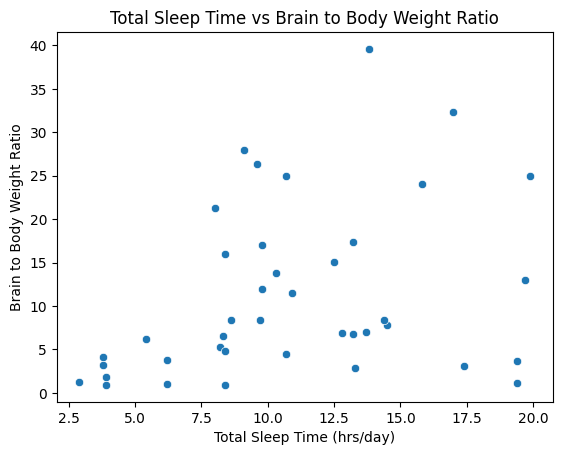

In [226]:
sns.scatterplot(x='Total sleep (hrs/day)', y=X['Brain Weight (g)'] / X['Body Weight (kg)'], data=y)

# Set title and labels
plt.title('Total Sleep Time vs Brain to Body Weight Ratio')
plt.xlabel('Total Sleep Time (hrs/day)')
plt.ylabel('Brain to Body Weight Ratio')

plt.show()

In [221]:
# get training pair from (mammal, species) make test train split, normalize
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
float_train = X_train.select_dtypes(include=['float64'])
cols = float_train.columns
float_train_scaled = scaler.fit_transform(float_train)
float_train_scaled = pd.DataFrame(float_train_scaled, columns=cols)
X_train.drop(float_train_scaled.columns, axis=1, inplace=True)
X_train = X_train.join(float_train_scaled)

float_test_scaled = scaler.transform(X_test.select_dtypes(include=['float64']))
float_test_scaled = pd.DataFrame(float_test_scaled, columns=cols)
X_test.drop(float_test_scaled.columns, axis=1, inplace=True)
X_test = X_test.join(float_test_scaled)

X_train.head(), X_test.head(), len(X_train), len(X_test)




(    Predation index  Sleep exposure index  Overall danger index  \
 39                2                     1                     1   
 6                 1                     1                     1   
 25                2                     1                     1   
 9                 1                     1                     1   
 13                5                     5                     5   
 
     Body Weight (kg)  Brain Weight (g)  Maximum life span (years)  \
 39               NaN               NaN                        NaN   
 6           0.021787          0.037966                   0.183673   
 25          0.000005          0.000033                   0.012245   
 9           0.000664          0.001314                   0.030612   
 13          0.000304          0.000706                   0.040816   
 
     Gestation time (days)  18-1_BasalMetRate_mLO2hr  22-1_HomeRange_km2  \
 39                    NaN                       NaN                 NaN   
 6              

In [222]:
# regress
# this seems to be hard to regress on- just regress on total sleep
dtrain = xgb.DMatrix(X_train, label=y_train.drop(['Species of animal'], axis=1)[['Total sleep (hrs/day)']])

param_grid = {
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.1, 0.2, 0.3],
    'min_child_weight': [1, 2, 3],
    'n_estimators': [100, 250, 500, 1000],
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator = xgb_model, param_grid = param_grid,
                          cv = 10, n_jobs = -1, verbose = 2)

model = grid_search.fit(X_train, y_train.drop(['Species of animal'], axis=1)[['Total sleep (hrs/day)']])

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


In [223]:
# eval on test set
dtest = xgb.DMatrix(X_test, label=y_test.drop(['Species of animal'], axis=1)[['Total sleep (hrs/day)']])
y_pred = model.predict(X_test)
i = 0
for _, row in y_test[['Total sleep (hrs/day)', 'Species of animal']].iterrows():
  print(row, y_pred[i])
  i += 1
mse = mean_squared_error(y_test.drop(['Species of animal'], axis=1)[['Total sleep (hrs/day)']], y_pred)
print("MSE: %.2f" % mse)


Total sleep (hrs/day)                          9.1
Species of animal        lesser short-tailed shrew
Name: 19, dtype: object 10.550751
Total sleep (hrs/day)               13.8
Species of animal        ground squirrel
Name: 16, dtype: object 9.282111
Total sleep (hrs/day)          6.2
Species of animal        gray seal
Name: 15, dtype: object 8.232768
Total sleep (hrs/day)          17.0
Species of animal        owl monkey
Name: 26, dtype: object 10.8252735
Total sleep (hrs/day)                6.2
Species of animal        brazilian tapir
Name: 4, dtype: object 7.668399
Total sleep (hrs/day)      10.7
Species of animal        galago
Name: 12, dtype: object 10.8252735
Total sleep (hrs/day)          15.8
Species of animal        tree shrew
Name: 37, dtype: object 8.0905285
Total sleep (hrs/day)            10.9
Species of animal        patas monkey
Name: 27, dtype: object 9.20564
MSE: 16.16
